<a href="https://colab.research.google.com/github/girijeshcse/car_finder/blob/nitya/Car_model_training_0812.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import sys
import numpy as np
import decimal
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import pickle
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [305]:
BASE_PATH = '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/'
TRAIN_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Train Images"])
TEST_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Test Images"])
TRAIN_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Train Annotations.csv"])
TEST_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Test Annotation.csv"])
CAR_NAMES_MAKE_DICT = os.path.sep.join([BASE_PATH, "Car names and make.csv"])

In [303]:
train_anno_df=pd.read_csv(TRAIN_ANNOTS_PATH)
train_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)

In [306]:
test_anno_df=pd.read_csv(TEST_ANNOTS_PATH)
test_anno_df.rename(columns={'Bounding Box coordinates': 'x0', 'Unnamed: 2': 'y0','Unnamed: 3': 'x1','Unnamed: 4': 'y1'}, inplace=True)

In [ ]:
# load the contents of the CSV annotations file
# initialize the list of data (images), our target output predictions
# (bounding box coordinates), along with the filenames of the
# individual images
data = []
targets = []
trainfilenames = []
testfilenames = []
labels = []
bboxes = []
trainimagePaths = []

In [ ]:
import pandas as pd 
car_map = pd.read_csv(CAR_NAMES_MAKE_DICT,names=['Cars'])
car_map = car_map.set_index('Cars')

In [ ]:
car_map_dict=car_map.to_dict('index')
list(car_map_dict.items())[:5]

[('AM General Hummer SUV 2000', {}),
 ('Acura RL Sedan 2012', {}),
 ('Acura TL Sedan 2012', {}),
 ('Acura TL Type-S 2008', {}),
 ('Acura TSX Sedan 2012', {})]

In [ ]:
#fetch a key based on value passed - we need this to build our image paths
print(list(car_map_dict.keys())[173])

Ram C/V Cargo Van Minivan 2012


In [366]:
import csv
with open(TRAIN_ANNOTS_PATH, newline='') as file:
    
    reader = csv.reader(file, delimiter = ' ')
    
    # store the headers in a separate variable,
    # move the reader object to point on the next row
    headings = next(reader)
      
    # output list to store all rows
    Output = []
    for row in reader:
        Output.append(row[:])
  
for row in Output:
    row = str(row)
    row = row.split(",")
    (filename, startX, startY, endX, endY, label) = row
    filename = filename.split("'",1)  

In [368]:
dfRows=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012'):
  limit=0
  if len(filenames) < 200 or 200 == 0:
    limit=len(filenames)
  else:
    limit=200
  for i in range(0,limit):
    if not os.path.isfile(os.path.join('/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images', filenames[i])):
      processedRows=[]
      filename=filenames[i]
      imagePathtrain=os.path.join(dirname, filename)
      pathSplits=imagePathtrain.split('/')[-1]
      pathSplits1=imagePathtrain.split('/')[-2]
      processedRows.append(pathSplits)
      processedRows.append(pathSplits1[:-4])
      processedRows.append(pathSplits1[-4:])
      image = cv2.imread(imagePathtrain)
      (h, w) = image.shape[:2]
      # scale the bounding box coordinates relative to the spatial dimensions of the input image
      startX = float(startX) 
      startY = float(startY) 
      endX = float(endX)
      endY = float(endY)
      processedRows.append(startX)
      processedRows.append(startY)
      processedRows.append(endX)
      processedRows.append(endY)
      # load the image and preprocess it
      image = load_img(imagePathtrain, target_size=(224, 224))
      image_array = img_to_array(image)
      processedRows.append(image_array)
      dfRows.append(processedRows)
      df=pd.DataFrame(dfRows, columns=["image_name","Car Name","Car Year","startX","startY", "endX", "endY","image_array"]) 

In [369]:
df.head(5)

,image_name,Car Name,Car Year,startX,startY,endX,endY,image_array
0,01034.jpg,Acura RL Sedan,2012,20.0,240.0,862.0,677.0,"[[[134.0, 135.0, 139.0], [140.0, 141.0, 146.0]..."
1,03767.jpg,Acura RL Sedan,2012,20.0,240.0,862.0,677.0,"[[[95.0, 72.0, 31.0], [100.0, 75.0, 35.0], [10..."
2,06839.jpg,Acura RL Sedan,2012,20.0,240.0,862.0,677.0,"[[[184.0, 187.0, 204.0], [182.0, 185.0, 202.0]..."
3,01535.jpg,Acura RL Sedan,2012,20.0,240.0,862.0,677.0,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]..."
4,03875.jpg,Acura RL Sedan,2012,20.0,240.0,862.0,677.0,"[[[27.0, 37.0, 46.0], [28.0, 38.0, 47.0], [22...."


In [ ]:
#df.to_csv('/content/drive/MyDrive/Capstone/Dataset_1/Imgarray.csv')           

In [ ]:
df.head(4)

,imagePathtrain,startX,startY,endX,endY,image_array
0,/content/drive/MyDrive/Capstone/Dataset_1/Data...,20,691,897,1951,"[[[134.0, 135.0, 139.0], [140.0, 141.0, 146.0]..."
1,/content/drive/MyDrive/Capstone/Dataset_1/Data...,66,3455,2990,9755,"[[[95.0, 72.0, 31.0], [100.0, 75.0, 35.0], [10..."
2,/content/drive/MyDrive/Capstone/Dataset_1/Data...,220,21067,9966,59481,"[[[184.0, 187.0, 204.0], [182.0, 185.0, 202.0]..."
3,/content/drive/MyDrive/Capstone/Dataset_1/Data...,488,93631,22146,264360,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]..."


In [370]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def drowBoxedImages(dataFrame,featureCol,x0,y0,x1,y1,boxlinewidth,boxedgecolor):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    #print(data)
    img = tf.keras.utils.array_to_img(data)
    ax[index].imshow(img)
    image_height, image_width, _ = data.shape
    rect=[]
    rect.append(patches.Rectangle((row[x0], row[y0]), row[x1] - row[x0], row[y1] - row[y0], linewidth=boxlinewidth, edgecolor=boxedgecolor, facecolor='none'))
    # Add the patch to the Axes
    for l in range(0,len(rect)):
      ax[index].add_patch(rect[l])
  plt.show()

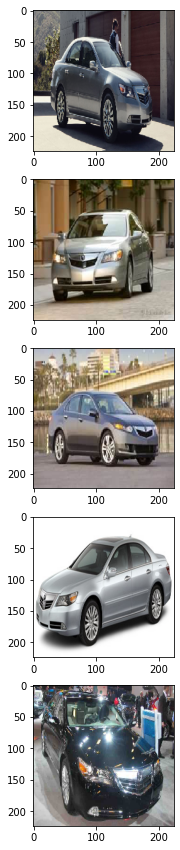

In [371]:
drowBoxedImages(df.head(5),'image_array','startX','startY','endX','endY',2,'r')